In [1]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
folder=os.listdir('/kaggle/input/brain-tumor-data/data_final')
folder.sort()
folder

['converted_images', 'converted_masks']

In [3]:
image_files = sorted(os.listdir('/kaggle/input/brain-tumor-data/data_final/converted_images'))
mask_files = sorted(os.listdir('/kaggle/input/brain-tumor-data/data_final/converted_masks'))

print(image_files[:5])
print("=================")
print(mask_files[:5])

['1.png', '10.png', '100.png', '1000.png', '1001.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png']


In [4]:
def print_imShape():
    idx = np.random.randint(0, len(image_files))
    
    imagePath = os.path.join('/kaggle/input/brain-tumor-data/data_final/converted_images', image_files[idx])
    maskPath = os.path.join('/kaggle/input/brain-tumor-data/data_final/converted_masks', mask_files[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape, mask.shape)

In [5]:
def plot_images():
    idx = np.random.randint(0, len(image_files))
    
    imagePath = os.path.join('/kaggle/input/brain-tumor-data/data_final/converted_images', image_files[idx])
    maskPath = os.path.join('/kaggle/input/brain-tumor-data/data_final/converted_masks', mask_files[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1, 3, figsize=[13, 15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

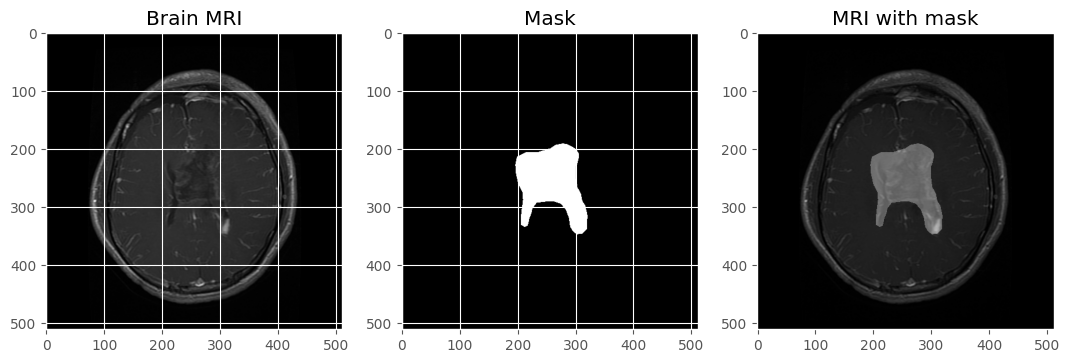

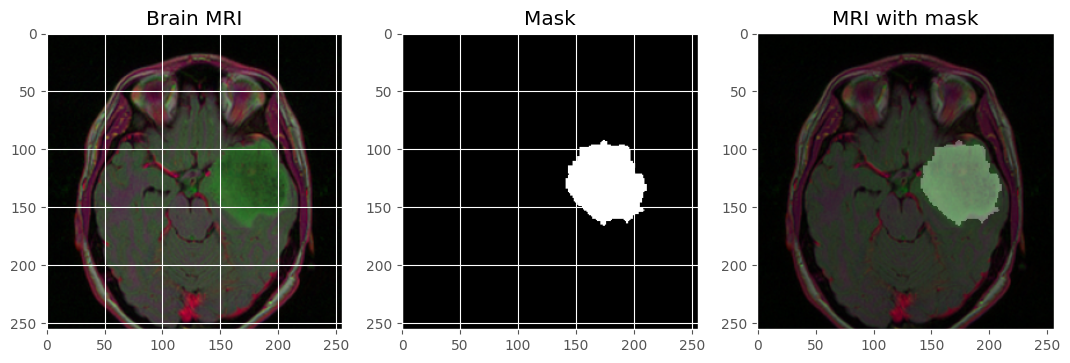

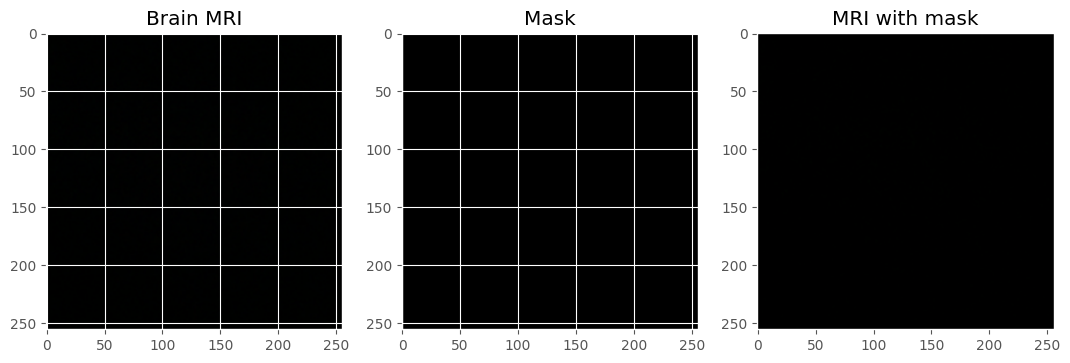

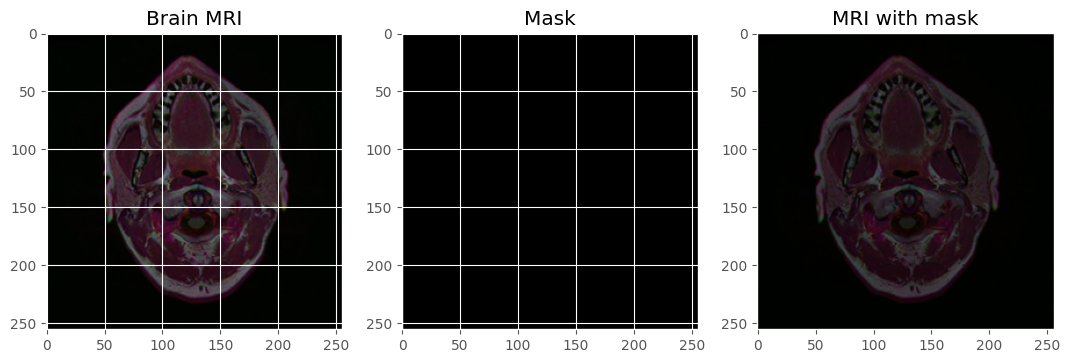

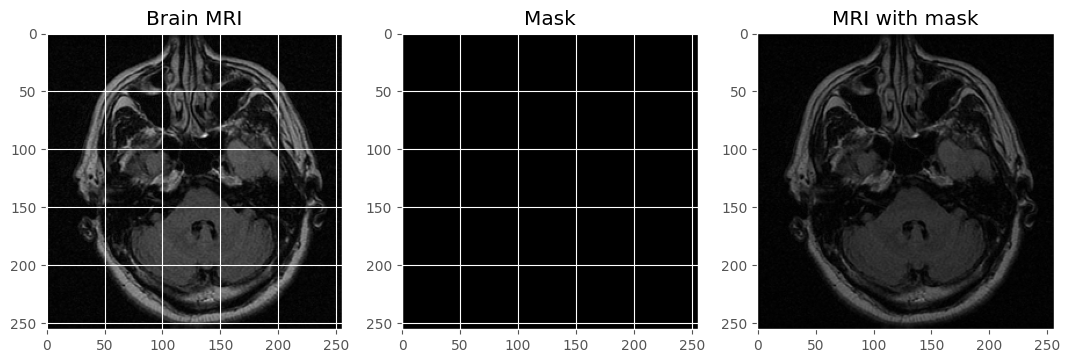

In [6]:
for i in range(5):
    plot_images()

In [7]:
for i in range(5):
    print_imShape()

(256, 256, 3) (256, 256, 3)
(512, 512, 3) (512, 512, 3)
(512, 512, 3) (512, 512, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


In [8]:
DataPath = '/kaggle/input/brain-tumor-data/data_final'

In [9]:
imagePath_df = pd.DataFrame()
imagePath_df['image-path'] = [os.path.join(DataPath, 'converted_images', img) for img in image_files]
imagePath_df['mask-path'] = [os.path.join(DataPath, 'converted_masks', msk) for msk in mask_files]

In [10]:
train , test = train_test_split(imagePath_df, test_size=0.25, random_state=21)


In [11]:
EPOCHS = 30
BATCH_SIZE = 20
ImgHieght = 512
ImgWidth = 512
Channels = 3

In [12]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [13]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 5244 validated image filenames.
Found 5244 validated image filenames.


In [14]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 1749 validated image filenames.
Found 1749 validated image filenames.


In [15]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [16]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

In [17]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [18]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [19]:
input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)


In [20]:
model.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[
        "accuracy", 
        Precision(), 
        Recall(), 
        AUC()  # Area Under the Curve
    ]
)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │        448 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_2[0][0] 

 Total params: 1,179,409 (4.50 MB)

 Trainable params: 1,177,937 (4.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [22]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [23]:
STEP_SIZE_TRAIN =int( timage_generator.n/BATCH_SIZE)
STEP_SIZE_VALID = int(vimage_generator.n/BATCH_SIZE)

In [24]:
results = model.fit(
    train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID
)


Epoch 1/30


I0000 00:00:1734252968.228559     104 service.cc:145] XLA service 0x7b2920005030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734252968.228651     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734252968.228658     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-15 08:56:54.508506: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,512,512]{3,2,1,0}, f32[20,16,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-15 08:56:57.335682: E external/local_xla/x

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9645 - auc: 0.6235 - loss: 0.2153 - precision: 0.0660 - recall: 0.0752
Epoch 1: val_loss improved from inf to 0.07610, saving model to model-brain.weights.h5
262/262 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.9645 - auc: 0.6238 - loss: 0.2150 - precision: 0.0662 - recall: 0.0751 - val_accuracy: 0.9867 - val_auc: 0.4772 - val_loss: 0.0761 - val_precision: 0.4037 - val_recall: 0.0219 - learning_rate: 0.0010
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9861 - auc: 0.8785 - loss: 0.0643 - precision: 0.5056 - recall: 0.1138
Epoch 2: val_loss improved from 0.07610 to 0.05417, saving model to model-brain.weights.h5
262/262 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9861 - auc: 0.8785 - loss: 0.0642 - precision: 0.5057 - recall: 0.1138 - val_accuracy: 0.9871 - val_auc: 0.9109 - val_loss: 0.0542 - val_precision: 0.5281 - val_recall: 0.1061 - learning_rate: 0.0010
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/ste

In [ ]:
results = model.fit(
    train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=20,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID
)


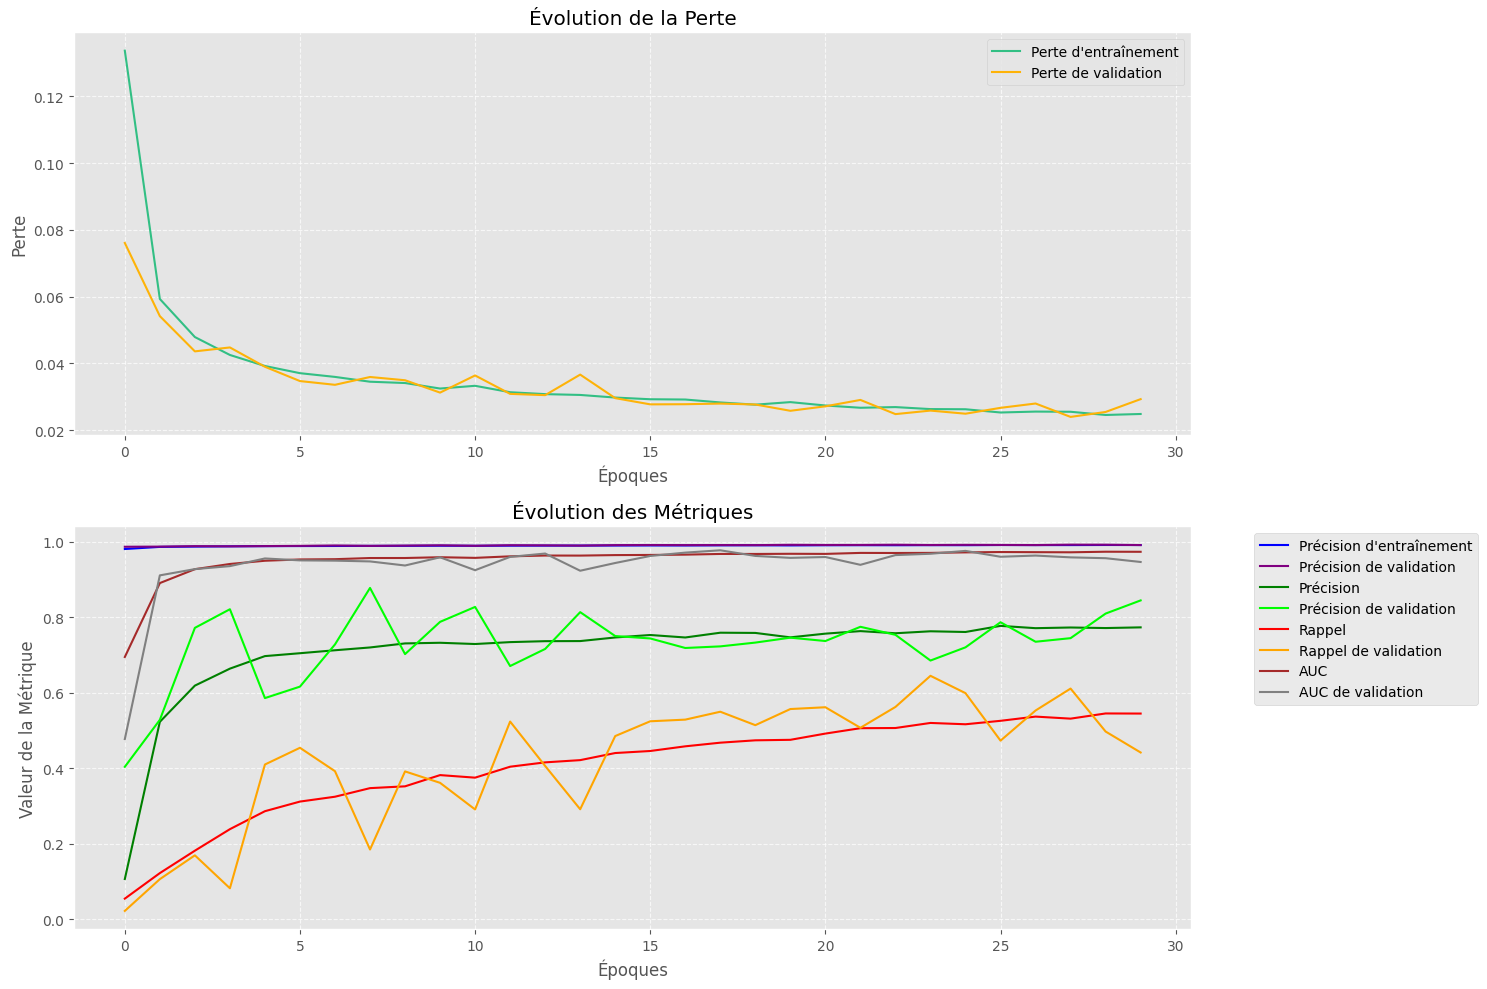

In [25]:
plt.figure(figsize=(15, 10))

# Graphiques des pertes
plt.subplot(2, 1, 1)
plt.plot(results.history["loss"], label="Perte d'entraînement", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="Perte de validation", color=sns.xkcd_rgb['amber'])
plt.title("Évolution de la Perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Graphiques des métriques
plt.subplot(2, 1, 2)
plt.plot(results.history["accuracy"], label="Précision d'entraînement", color='blue')
plt.plot(results.history["val_accuracy"], label="Précision de validation", color='purple')
plt.plot(results.history["precision"], label="Précision", color='green')
plt.plot(results.history["val_precision"], label="Précision de validation", color='lime')
plt.plot(results.history["recall"], label="Rappel", color='red')
plt.plot(results.history["val_recall"], label="Rappel de validation", color='orange')
plt.plot(results.history["auc"], label="AUC", color='brown')
plt.plot(results.history["val_auc"], label="AUC de validation", color='gray')

plt.title("Évolution des Métriques")
plt.xlabel("Époques")
plt.ylabel("Valeur de la Métrique")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [26]:
# load the best model
model.load_weights('model-brain.weights.h5')

In [27]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 0.9920 - auc: 0.9557 - loss: 0.0252 - precision: 0.7385 - recall: 0.6009


In [28]:
ImgHeight = 512
ImgWidth = 512


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


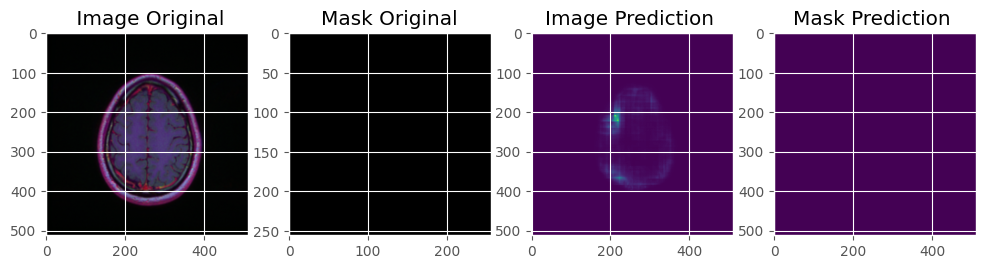

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


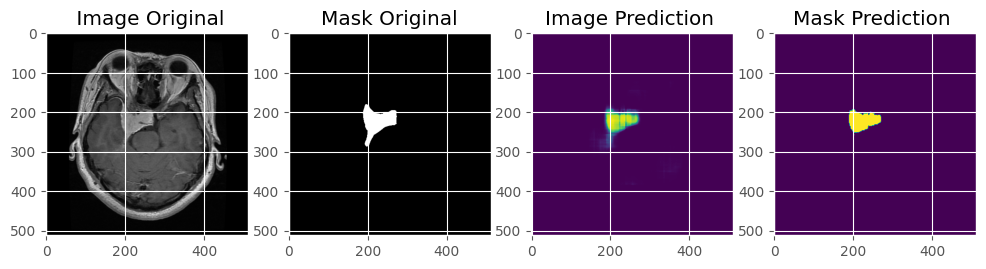

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


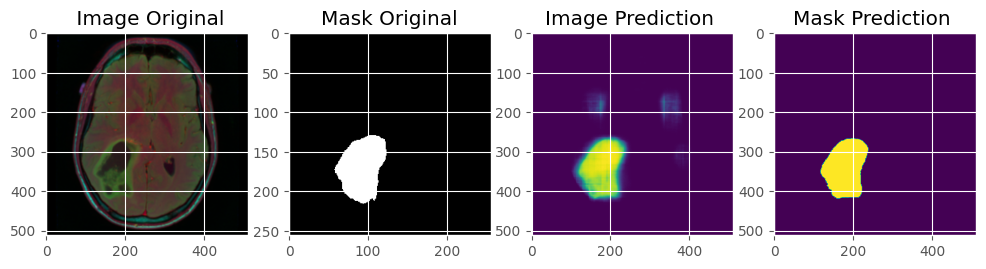

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


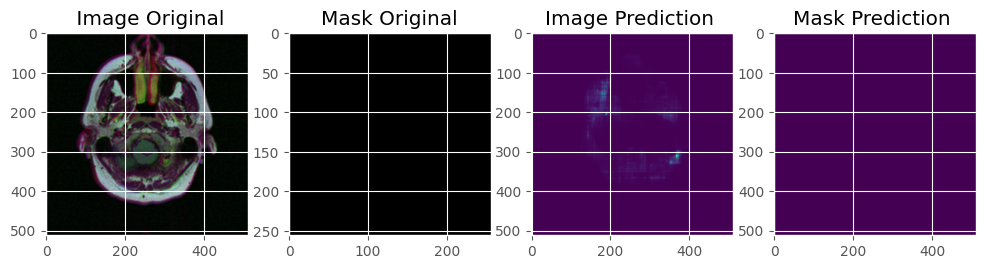

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


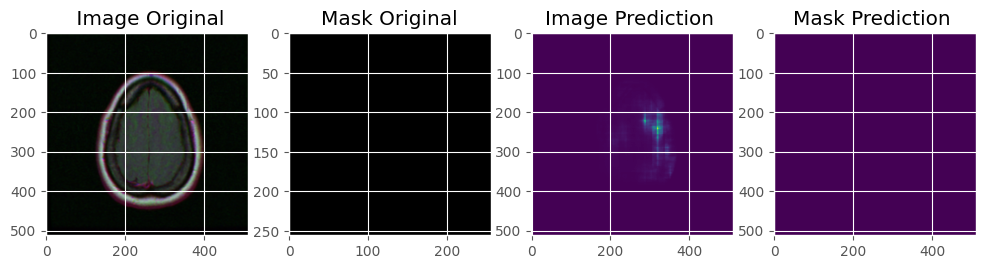

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


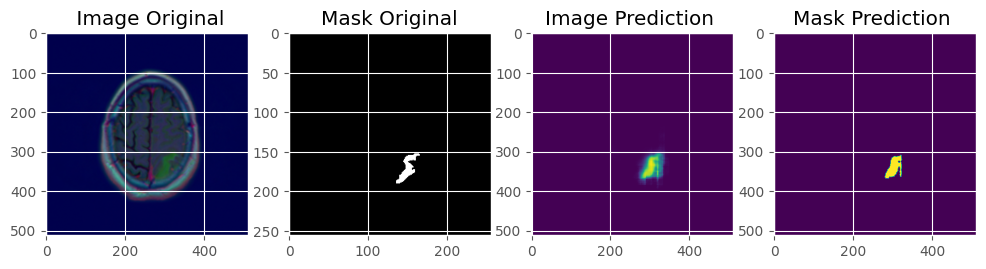

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


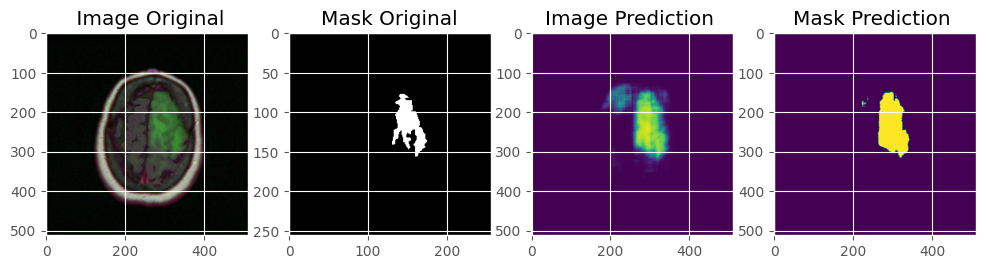

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


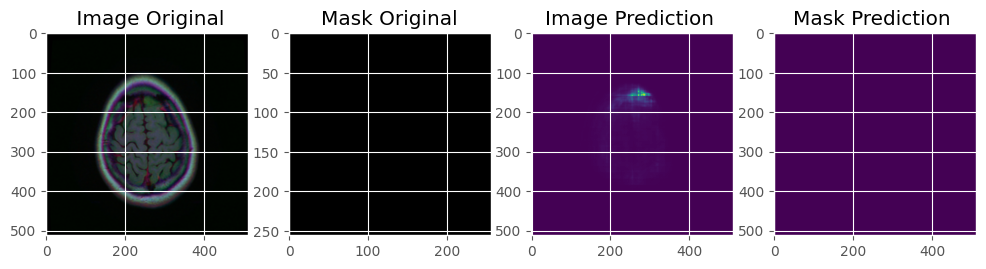

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


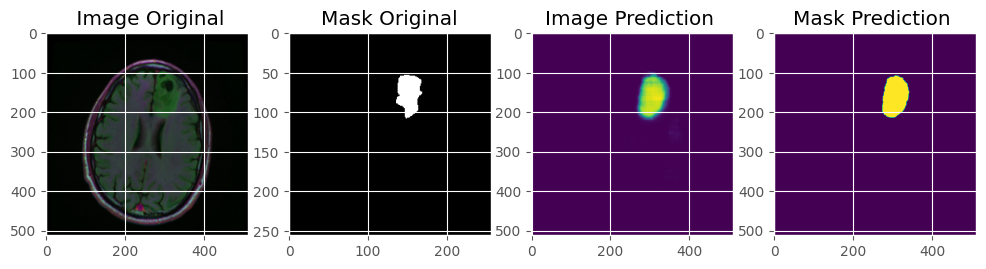

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


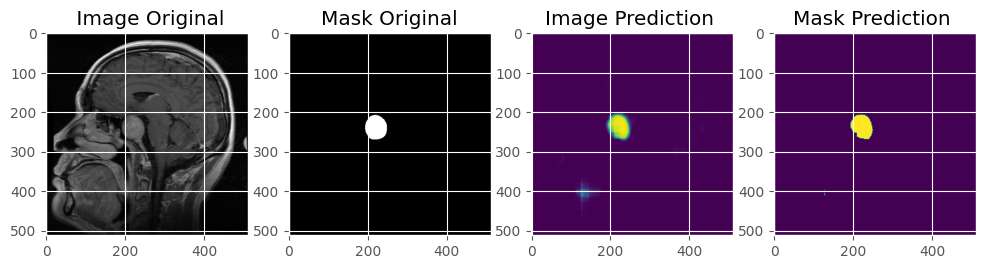

In [29]:

for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = imagePath_df['image-path'].iloc[idx]
    maskPath = imagePath_df['mask-path'].iloc[idx]
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image, (ImgHeight, ImgWidth))
    img = img / 255.0
    img = img[np.newaxis, :, :, :]
    
    pred = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 4, 1)
    plt.imshow(np.squeeze(img))
    plt.title(' Image Original')
    
    plt.subplot(1, 4, 2)
    plt.imshow(mask)
    plt.title('Mask Original')
    
    plt.subplot(1, 4, 3)
    plt.imshow(np.squeeze(pred))
    plt.title('Image Prediction ')
    
    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('Mask Prediction ')
    
    plt.show()